In [2]:
#May 11

import ares
import numpy as np
import matplotlib.pyplot as pl

Set up stuff to compare to

In [3]:
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'eldridge2009',

 'pop_fstar': 'pq', #parameteralized
 'pq_func': 'dpl', #double power law DoublePowerLaw class
    
 'pq_func_par0': 0.05,
 'pq_func_par1': 2.8e11,
 'pq_func_par2': 0.51,
 'pq_func_par3': -0.61,
 'pq_func_par4': 1e10,
}

# HaloMassFunction
pop_halo = ares.populations.HaloPopulation()
pop = ares.populations.GalaxyPopulation(**pars)

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020


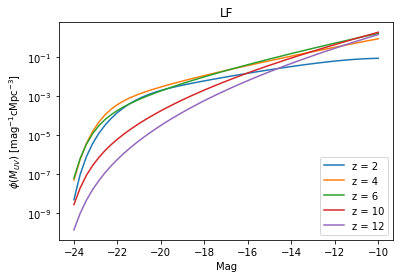

In [4]:
#the shape of a normal LF for comparision
pl.figure(1)
MUV = np.linspace(-24, -10)

for z in [2, 4, 6, 10, 12]:
    lf = pop.LuminosityFunction(z, MUV)
    pl.semilogy(MUV, lf, label='z = %i' %z)
    
pl.ylabel('$\phi(M_{UV})$ [mag$^{-1}$cMpc$^{-3}$]')
pl.xlabel('Mag')
pl.title('LF')
pl.legend()
pl.show()

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


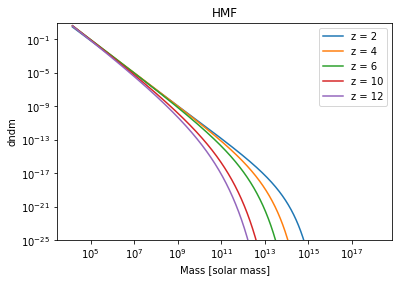

In [5]:
# mass function at a few redshifts
# The differential halo mass function, i.e., number of halos per mass bin, dn/dm. Note that the shape should be (len(z), ``len(M)).

for z in [2, 4, 6, 10, 12]:
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z)) #Returns the indices of the min value (so with z-zArray, this min value corresponds to the value closest to z)

    pl.loglog(pop_halo.halos.tab_M, pop_halo.halos.tab_dndm[i, :], label='z = %i' %z)
    
pl.legend()
pl.ylabel('dndm')
pl.xlabel('Mass [solar mass]')
pl.title('HMF')

pl.ylim(1e-25, 10)
pl.show()

### First a linear relation of HMF to LF
- assuming 1 halo = 1 galaxy

LF = c*hmf  
[c] = [solar mass]

In [6]:
# g_per_msun -> solar mass in grams

#really the problem is mass to Mag

from ares.physics.Constants import g_per_msun, cm_per_mpc

def LF_linear(z, pop_halo, const):
    
#     const = 1e3
    c = const #* g_per_msun / 1000 #solar mass - so there are kg here - that seems bad - 
    #really we are multiplying by solar masses here, but there's no numerical conversion from that
#     print(c) #very very small
    
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    LF = c * pop_halo.halos.tab_dndm[i, :]
    
    return LF

C:\Users\Emma\Anaconda3\lib\site-packages\numpy\ma\core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!


C:\Users\Emma\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


# WARNING: weisz2014 wavelength=1700.0A, not 1600.0A!
# WARNING: vanderburg2010 wavelength=1500.0A, not 1600.0A!
# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!
# WARNING: morishita2018 wavelength=1500.0A, not 1600.0A!


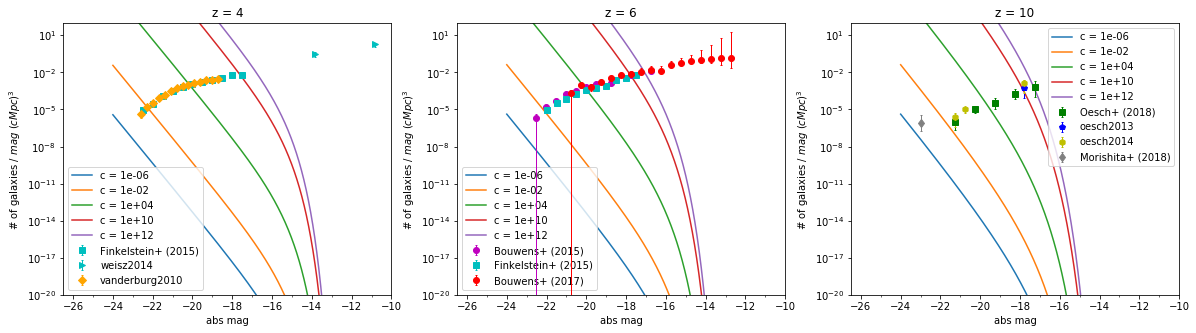

In [7]:
# mag = mass_to_mag(pop_halo.halos.tab_M)
obslf = ares.analysis.GalaxyPopulation() #for lit values

fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([4, 6, 10]):
   
    obslf.Plot(z=z, round_z=0.2, ax=axs[i]) 

    for c in [1e-6, 1e-2, 1e4, 1e10, 1e12,]:
        lf = LF_linear(z, pop_halo, c)

        MUV = np.linspace(-24, -10, num=len(lf))
        #do i just assume this and then the scaling just moves it - then I need to make sure lengths match
        #the problem with this is by changing the bounds of MUV the scaling will change

        axs[i].semilogy(MUV, lf, label='c = %.e' %c)
        
    axs[i].set_title("z = %i" %z)
    axs[i].legend()
    axs[i].set(xlabel='abs mag', ylabel='# of galaxies / $ mag~(cMpc)^3$')
    axs[i].set_ylim(1e-20, 1e2)
#     axs[i].set_xlim(-35, 0)

pl.show()

In [8]:
# For plotting a couple lines on the same plot for comparision

# for i, z in enumerate([4, 6, 10]):

#     for c in [1e-6, 1e10]:
#         lf = LF_linear(z, pop_halo, c)
#         MUV = np.linspace(-24, -10, num=len(lf)) #do i just assume this and then the scaling just moves it - then I need to make sure lengths match

#         pl.semilogy(MUV, lf, label='c = %.e, z = %i' %(c, z))

#     pl.legend()
#     pl.ylabel('# of galaxies / $ mag~(cMpc)^3$')
#     pl.xlabel('abs mag')
#     pl.ylim(1e-25, 1)

# pl.show()

### Now relating luminosity to mass linearly

Assume $L = c(mass)$ with [c] = [solar mass s /J]  
which then gives (using M_o and L_o constants for reference)  
$M-M_o = -2.5 log_{10}(\frac{c(mass)}{L_o})$ (this is how we get the new x axis values).  
Then using the prob. change of vars, we get dM/dmass and  

$LF = |\frac{ln(10)mass}{-2.5}|~hmf(M(mass))$ 

In [9]:
#doesn't actually use c now here
def LF_linearLog(z, pop_halo, const):
    
    c = const
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    LF = (np.log(10)*pop_halo.halos.tab_M)/2.5 * pop_halo.halos.tab_dndm[i, :]
    
    return LF

# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!
# WARNING: weisz2014 wavelength=1700.0A, not 1600.0A!
# WARNING: vanderburg2010 wavelength=1500.0A, not 1600.0A!
# WARNING: finkelstein2015 wavelength=1500.0A, not 1600.0A!
# WARNING: morishita2018 wavelength=1500.0A, not 1600.0A!


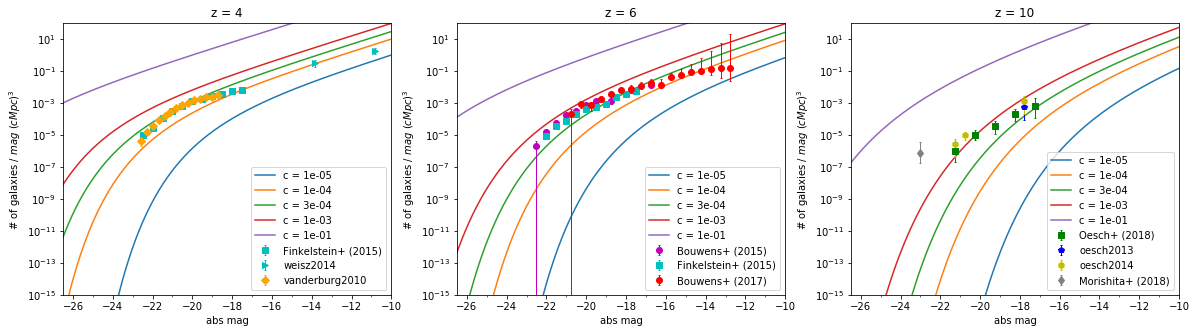

In [10]:
z = [4, 6, 10]

fig, axs = pl.subplots(1, len(z), figsize=(20, 5))

obslf = ares.analysis.GalaxyPopulation() #for lit values

for i, z in enumerate(z):
   
    obslf.Plot(z=z, round_z=0.2, ax=axs[i]) 
#     lf = pop.LuminosityFunction(z, MUV)
#     axs[i].semilogy(MUV, lf)

    for c in [1e-5, 1e-4, 3e-4, 1e-3, 1e-1]:
        lf = LF_linearLog(z, pop_halo, c)

#         MUV = np.linspace(-24, -10, num=len(lf))
        MUV = -2.5*np.log10(c*pop_halo.halos.tab_M)

        axs[i].semilogy(MUV, lf, label='c = %.e' %c)
        
    axs[i].set_title("z = %i" %z)
    axs[i].legend()
    axs[i].set(xlabel='abs mag', ylabel='# of galaxies / $ mag~(cMpc)^3$')
    axs[i].set_ylim(1e-15, 1e2)
#     axs[i].set_xlim(-35, 0)

pl.show()

looking in to sfr, but I think what I have so far is only the f* part

In [11]:
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'eldridge2009',

 'pop_fstar': 'pq', #parametseralized
 'pq_func': 'dpl', #double power law DoublePowerLaw class
    
 'pq_func_var'  :  'Mh',
  'Mh' : pop_halo.halos.tab_M,
 'pq_func_par0': 0.05,
 'pq_func_par1': 2.8e11,
 'pq_func_par2': 0.51,
 'pq_func_par3': -0.61,
 'pq_func_par4': 1e10,
}


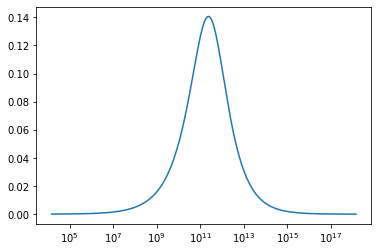

In [12]:
#this is the SFE I think

dpl = ares.phenom.ParameterizedQuantity(**pars)
pl.semilogx(pop_halo.halos.tab_M, dpl.__call__(**pars))
# pl.xlim(1e5, 1e15)
pl.show()

# pop_halo.MGR(z, pop_halo.halos.tab_M) increases fast at high mass and then plateaus, returns self._MAR
# MGR_integrated is just a number, but dependant on z

# pop_halo.halos.tab_M

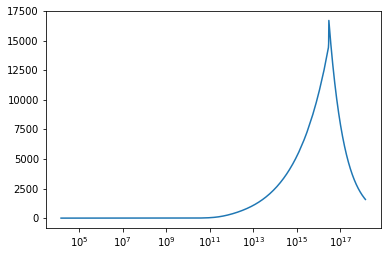

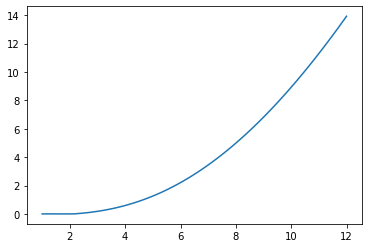

In [13]:
z = 6

# want model for the mass accretion rate * SFE * (cosmo const stuff)
#is MGR the same as MAR or not?

pl.semilogx(pop_halo.halos.tab_M, dpl.__call__(**pars)*pop_halo.MGR(z, pop_halo.halos.tab_M) ) 
pl.show()

#I think this is what I want
z = np.linspace(1, 12, 100)
pl.plot(z, pop_halo.MGR(z, pop_halo.halos.tab_M[500]) ) 
pl.show()

# print( pop_halo.MGR_integrated() )
# pl.show()

# pop_MAR


### Looking at lower Z we need SMF

C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1244: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


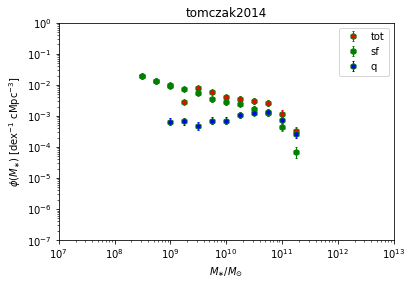

In [14]:
t14 = ares.util.read_lit("tomczak2014")
# t14.data
obslf = ares.analysis.GalaxyPopulation()

# look for smf at lower z

# print("z = 2.25, 2.75")
pl.figure(1)
# obslf.PlotSMF(0.875, sources="tomczak2014", round_z=0.2,color="b", ecolor='b', label="q, z = 0.875", quantity="smf_tot")
# obslf.PlotSMF(1.125, sources="tomczak2014", round_z=0.2,color="purple", ecolor='purple', label="q, z = 1.125", quantity="smf_tot")
# obslf.PlotSMF(1.75, sources="tomczak2014", round_z=0.2,color="r", ecolor='r', label="q, z = 1.75", quantity="smf_tot")

z = 0.875
obslf.PlotSMF(z, sources="tomczak2014", color="r", ecolor='r', label="tot", quantity="smf_tot")
obslf.PlotSMF(z, sources="tomczak2014",  label="sf")
obslf.PlotSMF(z, sources="tomczak2014", color="b", ecolor='b', label="q", quantity="smf_q")

# smf_tot
pl.title("tomczak2014")
# pl.ylim(1e-5, 1e-4)
# pl.xlim(1e10, 1e12)

# pl.axhline(10.0**(-4.94), label="-4.94")
# pl.axhline(10.0**(-4.73), label="-4.73", color="purple")

pl.legend()

In [23]:
def SMF_linear(z, pop_halo, const):
    
#     const = 1e3
    c = const #stellar mass/halo mass sorta?
    
    i = np.argmin(np.abs(z - pop_halo.halos.tab_z))
    
    SMF = pop_halo.halos.tab_dndm[i, :] / c
    
    return SMF

# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=stefanon2017
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=duncan2014
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=stefanon2017
# Shifting stellar masses by 0.25 dex (Chabrier -> Salpeter) for source=duncan2014


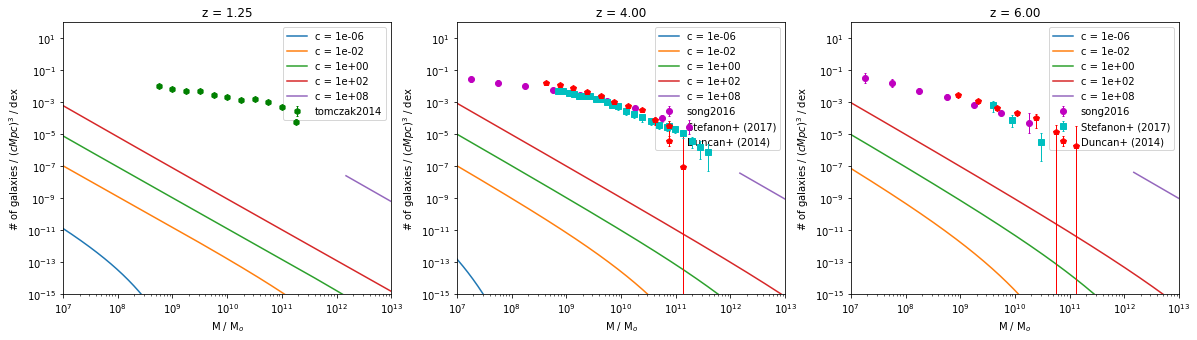

In [29]:
data = ares.analysis.GalaxyPopulation() #for lit values

fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([1.25, 4, 6]):
   
    data.PlotSMF(z=z, round_z=0.2, ax=axs[i]) 

    for c in [1e-6, 1e-2, 1, 1e2, 1e8]:
        SMF = SMF_linear(z, pop_halo, c)

#         SM = np.linspace(1e7, 1e12, num=len(SMF))
        SM = pop_halo.halos.tab_M*c
        #just scaling the x axis or is there a beter way??

        axs[i].loglog(SM, SMF, label='c = %.e' %c)
        
    axs[i].set_title("z = %.2f" %z)
    axs[i].legend()
    axs[i].set(xlabel='M / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-15, 1e2)
#     axs[i].set_xlim(-35, 0)

pl.show()

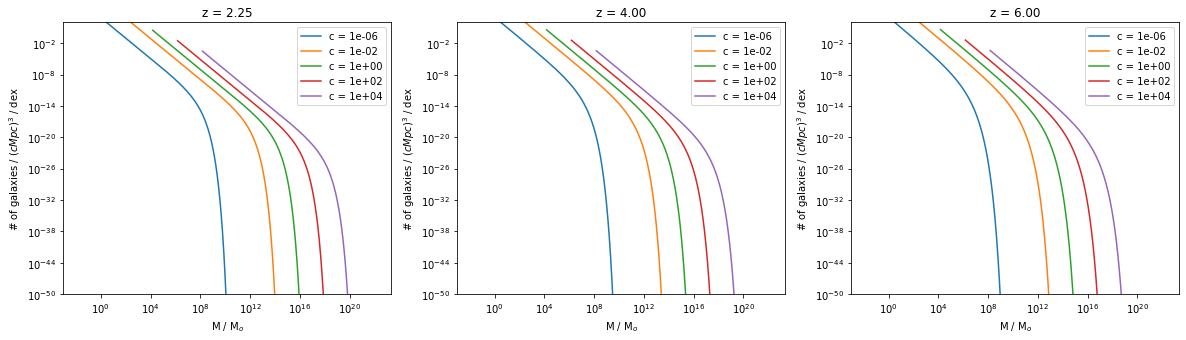

In [27]:
fig, axs = pl.subplots(1, 3, figsize=(20, 5))

for i, z in enumerate([2.25, 4, 6]):
   
#     data.PlotSMF(z=z, round_z=0.2, ax=axs[i]) 

    for c in [1e-6, 1e-2, 1, 1e2, 1e4]:
        SMF = SMF_linear(z, pop_halo, c)

#         SM = np.linspace(1e9, 1e12, num=len(SMF))
        SM = pop_halo.halos.tab_M*c
        #just scaling the x axis or is there a beter way??

        axs[i].loglog(SM, SMF, label='c = %.e' %c)
        
    axs[i].set_title("z = %.2f" %z)
    axs[i].legend()
    axs[i].set(xlabel='M / M$_o$', ylabel='# of galaxies / $ (cMpc)^3$ / dex')
    axs[i].set_ylim(1e-50, 1e2)
#     axs[i].set_xlim(-35, 0)

pl.show()